In [260]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


filepath = u"../data/cleaned_resume.csv"

data = pd.read_csv(filepath)
data = data.dropna()
data = data[["Sentence_#","Word","Tag"]]
data


,Sentence_#,Word,Tag
0,0,Govardhana,NAME
1,0,K,NAME
2,0,Senior,PROFIL
3,0,Software,PROFIL
4,0,Engineer,PROFIL
...,...,...,...
78268,4083,tuning,O
78269,4083,and,O
78270,4083,escalating,O
78271,4083,Security,O


In [ ]:
#change date tag to Date instead of 0
#data.loc[data.index[data.Word.str.contains("[0-9]{4}$")],'Tag'] = "Date"

In [261]:
data["Tag"].value_counts()

O                      68693
SKILLS                  3887
DATE                     970
PROFIL                   914
YEARS_OF_EXPERIENCE      759
COMPANIES_WORKED_AT      742
COLLEGE_NAME             737
DEGREE                   709
LOCATION                 318
NAME                     291
EMAIL_ADDRESS            197
Name: Tag, dtype: int64

In [263]:
## remove random O-Tag
#import random
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.7))

drop_indices = np.random.choice(index, O_tagSize, replace=False)
data = data.drop(drop_indices)

data["Tag"].value_counts()

O                      10303
SKILLS                  3887
DATE                     970
PROFIL                   914
YEARS_OF_EXPERIENCE      759
COMPANIES_WORKED_AT      742
COLLEGE_NAME             737
DEGREE                   709
LOCATION                 318
NAME                     291
EMAIL_ADDRESS            197
Name: Tag, dtype: int64

In [264]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

6255

In [265]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags
print(tags)

['SKILLS', 'DATE', 'YEARS_OF_EXPERIENCE', 'PROFIL', 'EMAIL_ADDRESS', 'DEGREE', 'LOCATION', 'O', 'COLLEGE_NAME', 'COMPANIES_WORKED_AT', 'NAME']


In [267]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence_#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            print(s)
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [268]:
sentences = getter.sentences
print("Length of sentences before O class removal {}".format(len(sentences)))
candidate_sentence= []
## remove the sentence containing only O tag
for sentence in sentences :
    o_nb=0
    for word in sentence:
        o_nb+= 1 if word[1]=="O" else 0
    if(o_nb<=math.floor(len(sentence))):
        #print(len(sentence),o_nb)
        candidate_sentence.append(sentence)
print("Length of sentences after O class removal {}".format(len(candidate_sentence)))

Length of sentences before O class removal 3559
Length of sentences after O class removal 3559


In [269]:
max_len = max([len(x) for x in candidate_sentence])
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
max_len

75

In [270]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentences= candidate_sentence
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[1]] for w in s] for s in sentences]


X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=n_words - 1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",value=tag2idx["O"])

In [271]:
# change label to categorical
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

#X = X.reshape(X.shape[0],X.shape[1],1)
#y = y.reshape(y.shape[0],y.shape[1],1)
#X.shape,y.shape

In [272]:
# split dataset into train (input & label) test (input & label)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
print(" X_tr,X_te  length - {} {} ".format(len(X_tr),len(X_te)))

 X_tr,X_te  length - 3203 356 


In [273]:
## try word embedding format word2vec
import multiprocessing
import gensim

from gensim.models import Word2Vec
import logging
from time import time

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = [[w[0] for w in sent] for sent in candidate_sentence]
type(sentences)

list

In [274]:
cores = multiprocessing.cpu_count()
cores

w2v_model = Word2Vec(min_count=5,
                     window=4,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
w2v_model.corpus_count

2020-05-30 19:07:30,627 : INFO : collecting all words and their counts
2020-05-30 19:07:30,629 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-30 19:07:30,643 : INFO : collected 6254 word types from a corpus of 19827 raw words and 3559 sentences
2020-05-30 19:07:30,645 : INFO : Loading a fresh vocabulary
2020-05-30 19:07:30,655 : INFO : effective_min_count=5 retains 604 unique words (9% of original 6254, drops 5650)
2020-05-30 19:07:30,657 : INFO : effective_min_count=5 leaves 11995 word corpus (60% of original 19827, drops 7832)
2020-05-30 19:07:30,667 : INFO : deleting the raw counts dictionary of 6254 items
2020-05-30 19:07:30,669 : INFO : sample=6e-05 downsamples 604 most-common words
2020-05-30 19:07:30,671 : INFO : downsampling leaves estimated 2359 word corpus (19.7% of prior 11995)
2020-05-30 19:07:30,676 : INFO : estimated required memory for 604 words and 300 dimensions: 1751600 bytes
2020-05-30 19:07:30,677 : INFO : resetting layer weights


Time to build vocab: 0.0 mins


3559

In [275]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

2020-05-30 19:07:33,159 : INFO : training model with 3 workers on 604 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=4
2020-05-30 19:07:33,175 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-30 19:07:33,185 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-30 19:07:33,188 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-30 19:07:33,190 : INFO : EPOCH - 1 : training on 19827 raw words (2282 effective words) took 0.0s, 107869 effective words/s
2020-05-30 19:07:33,207 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-30 19:07:33,221 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-30 19:07:33,225 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-30 19:07:33,226 : INFO : EPOCH - 2 : training on 19827 raw words (2350 effective words) took 0.0s, 101593 effective words/s
2020-05-30 19:07:33,239 : INFO : worker t

2020-05-30 19:07:33,870 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-30 19:07:33,889 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-30 19:07:33,893 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-30 19:07:33,895 : INFO : EPOCH - 21 : training on 19827 raw words (2397 effective words) took 0.0s, 82429 effective words/s
2020-05-30 19:07:33,918 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-30 19:07:33,925 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-30 19:07:33,928 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-30 19:07:33,930 : INFO : EPOCH - 22 : training on 19827 raw words (2247 effective words) took 0.0s, 102606 effective words/s
2020-05-30 19:07:33,943 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-30 19:07:33,972 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05

Time to train the model: 0.02 mins


In [276]:
import gensim
word_vectors  = w2v_model.wv

MAX_NB_WORDS = len(word_vectors.vocab)
WV_DIM = 50

nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(n_words, WV_DIM) - 0.5) / 5.0
for word, i in word2idx.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass
print(MAX_NB_WORDS)

604


In [277]:
from keras.layers import Embedding
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

test_sentence = ["html"]
#model =  tf.keras.models.load_model("./saved_model/lstm_ner_model_F1_37_3.h5")
embedding_layer = Embedding(n_words,
                     WV_DIM,
                     mask_zero=True,
                     weights=[wv_matrix],
                     input_length=max_len,
                     trainable=False)

In [279]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,SpatialDropout1D
from keras.layers.normalization import BatchNormalization

input = Input(shape=(max_len,))
#model = Embedding(input_dim=n_words + 1, output_dim=50,input_length=max_len, mask_zero=True)(input)
model = embedding_layer(input)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)
model.summary()


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 75, 50)            312750    
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 75, 50)            0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 75, 200)           120800    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 75, 11)            2211      
Total params: 435,761
Trainable params: 123,011
Non-trainable params: 312,750
_________________________________________________________________


In [280]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [281]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=10, validation_split=0.3, verbose=1,shuffle=True)

Train on 2242 samples, validate on 961 samples
Epoch 1/10
2242/2242 [==============================] - 18s 8ms/step - loss: 0.8981 - accuracy: 0.8512 - val_loss: 0.1462 - val_accuracy: 0.9697
Epoch 2/10
2242/2242 [==============================] - 16s 7ms/step - loss: 0.1637 - accuracy: 0.9614 - val_loss: 0.1290 - val_accuracy: 0.9697
Epoch 3/10
2242/2242 [==============================] - 17s 7ms/step - loss: 0.1535 - accuracy: 0.9614 - val_loss: 0.1213 - val_accuracy: 0.9697
Epoch 4/10
2242/2242 [==============================] - 17s 8ms/step - loss: 0.1498 - accuracy: 0.9614 - val_loss: 0.1246 - val_accuracy: 0.9697
Epoch 5/10
2242/2242 [==============================] - 17s 7ms/step - loss: 0.1366 - accuracy: 0.9615 - val_loss: 0.1109 - val_accuracy: 0.9699
Epoch 6/10
2242/2242 [==============================] - 17s 8ms/step - loss: 0.1358 - accuracy: 0.9619 - val_loss: 0.1080 - val_accuracy: 0.9706
Epoch 7/10
2242/2242 [==============================] - 17s 8ms/step - loss: 0.1249

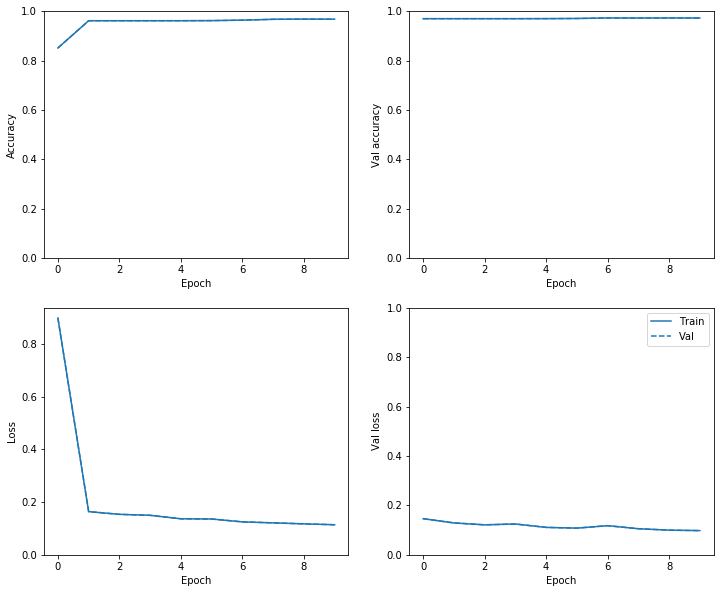

In [282]:
def plot_metrics(history):
    metrics =  ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history[metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
              plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
              plt.ylim([0.8,1])
        else:
              plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [283]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

356/356 [==============================] - 3s 7ms/step
F1-score: 39.7%
                     precision    recall  f1-score   support

       COLLEGE_NAME       0.00      0.00      0.00        17
             SKILLS       0.46      0.55      0.50       406
               DATE       0.00      0.00      0.00        75
COMPANIES_WORKED_AT       0.00      0.00      0.00        32
YEARS_OF_EXPERIENCE       0.00      0.00      0.00        40
             PROFIL       0.00      0.00      0.00        20
             DEGREE       0.00      0.00      0.00        19
           LOCATION       0.00      0.00      0.00        17
               NAME       0.00      0.00      0.00         7
      EMAIL_ADDRESS       0.00      0.00      0.00        11

          micro avg       0.46      0.35      0.40       644
          macro avg       0.29      0.35      0.32       644



In [285]:
i = 59
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
Configuration  : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
E

In [288]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_tr]
value = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
print(value)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

[ 1.78639152  5.82363636  6.06628788  3.16501976  8.56417112  5.02037618
 13.86580087  0.1112655  13.86580087  5.39225589  6.47070707]


In [289]:
history = model.fit(X_tr, np.array(y_tr), batch_size=128,epochs=5, shuffle=True,validation_split=0.3, verbose=1,class_weight=value)

Train on 2242 samples, validate on 961 samples
Epoch 1/5
2242/2242 [==============================] - 18s 8ms/step - loss: 0.1170 - accuracy: 0.9660 - val_loss: 0.0972 - val_accuracy: 0.9721
Epoch 2/5
2242/2242 [==============================] - 16s 7ms/step - loss: 0.1087 - accuracy: 0.9684 - val_loss: 0.0958 - val_accuracy: 0.9726
Epoch 3/5
2242/2242 [==============================] - 17s 8ms/step - loss: 0.1074 - accuracy: 0.9688 - val_loss: 0.0938 - val_accuracy: 0.9727
Epoch 4/5
2242/2242 [==============================] - 21s 9ms/step - loss: 0.1059 - accuracy: 0.9686 - val_loss: 0.0973 - val_accuracy: 0.9716
Epoch 5/5
2242/2242 [==============================] - 21s 9ms/step - loss: 0.1046 - accuracy: 0.9688 - val_loss: 0.0921 - val_accuracy: 0.9730


In [290]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

356/356 [==============================] - 3s 8ms/step
F1-score: 42.2%
                     precision    recall  f1-score   support

       COLLEGE_NAME       0.00      0.00      0.00        17
             SKILLS       0.51      0.58      0.54       406
               DATE       0.00      0.00      0.00        75
COMPANIES_WORKED_AT       0.00      0.00      0.00        32
YEARS_OF_EXPERIENCE       0.00      0.00      0.00        40
             PROFIL       0.00      0.00      0.00        20
             DEGREE       0.00      0.00      0.00        19
           LOCATION       0.00      0.00      0.00        17
               NAME       0.00      0.00      0.00         7
      EMAIL_ADDRESS       0.00      0.00      0.00        11

          micro avg       0.50      0.36      0.42       644
          macro avg       0.32      0.36      0.34       644



In [299]:
t1 =["Amadou","NDIAYE","23","years","old","Research","and","Development","Engineer","Training","2016","2019","Diploma","of","Design","Engineer","in","Telecommunications","and","Networks","DIC","Ecole","Supérieure","Polytechnique","de","Dakar","ESP","2014","2016"]
t2 = ["University",
"Diploma",
"of",
"Technology",
"in",
"Telecommunications",
"and",
"Networks",
"DUT",
"Ecole",
"Supérieure",
"Polytechnique",
"de",
"Dakar",
"ESP",
"2013",
"2014",
"Baccalaureate",
"Series",
"S1",
"Sangalcam",
"High",
"School"]
t3 =[
"Languages",
"English",
"Professional",
"French",
"Fluent",
"Wolof",
"Fluent",
"Pular",
"native",
"Technical",
"skills",
"BIG",
"DATA",
"Hadoop",
"2",
"Sqoop",
"2",
"Storm",
"2",
"Avro",
"1",
"5",
"Nifi",
"1",
"5",
"Ambari",
"1",
"5",
"AWS"]
t4 = [
"BIG",     
"DATA",    
"platform",
"for",     
"Atos",    
"Senegal", 
"Mission", 
"s",
"and",     
"Implementation", 
"of",      
"Ambari",  
"in",      
"a",
"6",
"node",    
"cluster", 
"achievements",   
"Installation",   
"of",      
"Hortonworks",    
"Data",    
"Platform",
"and",     
"various", 
"services",
"HDFS",    
"YARN",    
"HIVE",    
"SPARK",   
"SQOOP",   
"on",      
"the",     
"cluster", 
"Cluster", 
"administration", 
"user",    
"management"     
"file",    
"and",     
"service", 
"access",  
"management",     
"Environment",    
"Centos",  
"7",
"Hortonworks"    
    
]
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences
word2idx = {}
max_len = 50


with open("../app/word2idx.json", "r", encoding="utf-8") as f:
    word2idx = json.load(f)

with open("../app/tag2idx.json", "r", encoding="utf-8") as f:
    tag2idx = json.load(f)
tags = tag2idx.keys()

tags = list(tag2idx.keys())
tags

['Skills',
 'Email Address',
 'Name',
 'Degree',
 'Companies worked at',
 'Duration',
 'O',
 'Profil',
 'College Name',
 'Location',
 'Date']

In [293]:
import keras
import tensorflow as tf
import numpy as np
model2 =  tf.keras.models.load_model("../models/saved_model/lstm_ner_model_F1_37_3.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-30 19:17:07,471 : WARNING : From C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-30 19:17:07,483 : WARNING : From C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\ops\init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-30 19:17:07,486 : WARNING : From C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\ops\init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-05-30 19:17:07,489 : WARNING : From C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [296]:

test_sentence = t3
print(max_len)
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=50)

p = model2.predict(np.array([x_test_sent[0]]))

p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))
sequences=[[word2idx.get(w, 0) for w in test_sentence]]

50
Word           ||Prediction
Languages      : O    
English        : Skills
Professional   : O    
French         : O    
Fluent         : O    
Wolof          : O    
Fluent         : O    
Pular          : O    
native         : O    
Technical      : Skills
skills         : O    
BIG            : O    
DATA           : Skills
Hadoop         : Skills
2              : Skills
Sqoop          : O    
2              : Skills
Storm          : O    
2              : Skills
Avro           : O    
1              : Duration
5              : Duration
Nifi           : O    
1              : Duration
5              : Duration
Ambari         : O    
1              : Duration
5              : Duration
AWS            : Skills


In [300]:

sequences = [t1,t2,t3]
pred_dict = {}
for seq in sequences:
        pred_sentence = pad_sequences(sequences=[[word2idx.get(w, 0) for w in seq]],
                                      padding="post", value=0, maxlen=50)
        p = model2.predict(np.array([pred_sentence[0]]))
        p = np.argmax(p, axis=-1)
        for w, pred in zip(seq, p[0]):
            pred_dict[w] = tags[pred]
            print("{:15}: {:5}".format(w, tags[pred]))

Amadou         : O    
NDIAYE         : O    
23             : O    
years          : O    
old            : O    
Research       : O    
and            : O    
Development    : O    
Engineer       : O    
Training       : O    
2016           : O    
2019           : O    
Diploma        : Degree
of             : O    
Design         : O    
Engineer       : Profil
in             : O    
Telecommunications: O    
and            : O    
Networks       : O    
DIC            : O    
Ecole          : O    
Supérieure     : O    
Polytechnique  : O    
de             : O    
Dakar          : O    
ESP            : O    
2014           : Date 
2016           : Date 
University     : College Name
Diploma        : Degree
of             : Degree
Technology     : Degree
in             : Degree
Telecommunications: O    
and            : O    
Networks       : O    
DUT            : O    
Ecole          : O    
Supérieure     : O    
Polytechnique  : O    
de             : O    
Dakar          

In [309]:
import gensim
phraser = gensim.models.Phrases.load(r"../models/saved_model/phraser")
s = [w.lower() for w in t1]
sent = [u'data', u'science', u'of', u'new', u'york', u'was', u'there',u'software',u'engineer',"big","data",u"computer","science","machine","learning"]
print(phraser[s])

2020-05-30 19:36:13,172 : INFO : loading Phrases object from ../models/saved_model/phraser
2020-05-30 19:36:13,300 : INFO : loaded ../models/saved_model/phraser


['amadou', 'ndiaye', '23', 'years', 'old', 'research', 'and', 'development', 'engineer', 'training', '2016', '2019', 'diploma', 'of', 'design_engineer', 'in', 'telecommunications', 'and', 'networks', 'dic', 'ecole', 'supérieure', 'polytechnique', 'de', 'dakar', 'esp', '2014', '2016']
